<a href="https://colab.research.google.com/github/sridevibonthu/EVA/blob/master/S12/S12_Assignment_Task_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Loading Images and annotations from git

In [1]:
!git clone https://github.com/sridevibonthu/EVALibrary/tree/master/EVA4/Dogs

Cloning into 'Dogs'...
fatal: repository 'https://github.com/sridevibonthu/EVALibrary/tree/master/EVA4/Dogs/' not found


## Importing Libraries

In [0]:
import json  
import pandas as pd  
import math
from PIL import Image 
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from tqdm.notebook import tqdm, trange
import os
from skimage import io 
from sklearn import metrics 
from scipy.spatial.distance import cdist 



## Load Annotations from JSON file

In [0]:
with open('Dogannotations.json') as f:
  annot = json.load(f)

## Get Data

In [0]:

path = '/content/EVALibrary/EVA4/Dogs/'

sizedict = {}
for filename in os.listdir(path):
  #print(filename)
  if filename.endswith('jpg'):
    image = io.imread(f'{path}{filename}', as_gray=False, pilmode="RGB")
    sizedict[filename] = image.shape[:2]

## Sample Labelled Annotated Record with Description

```
 "Dog-13.jpg63606": {                  #Key of the Entry
    "filename": "Dog-13.jpg",          #Name of the Image File
    "size": 63606,                     #Image size in bytes
    "regions": [                       #List of dictionaries containing information about selected box (annotated region) and its class name
      {
        "shape_attributes": {
          "name": "rect",              # Shape of the box
          "x": 140,                    # Starting x-coordinate
          "y": 48,                     # Starting y-coordinate
          "width": 336,                # Width in pixels 
          "height": 305                # Height in pixels
        },
        "region_attributes": {
          "class": "dog"               # Class name for the selected region
        }
      }
    ],
    "file_attributes": {               # attributes of file, url if is taken from online. not needed
      "caption": "",
      "public_domain": "no",
      "image_url": ""
    }
  },
```



### Prepare Data for clustering

In [5]:
import pandas as pd
import math
df = pd.DataFrame()

data = []
for k, v in annot.items():
  for r in v['regions']:
    d = {'name': v['filename'] }
    s = r['shape_attributes']
    h, w = sizedict[v['filename']]
    d['h'] = s['height']
    d['w'] = s['width']
    d['x'] = s['x']
    d['y'] = s['y']
    d['image_w'] = w
    d['image_h'] = h
    d['height'] = s['height']/h
    d['width'] = s['width']/w
    d['log_height'] = math.log(s['height']/h)
    d['log_width'] = math.log(s['width']/h)

    data.append(d)


df = pd.DataFrame.from_dict(data, orient='columns')
df.head()

,name,h,w,x,y,image_w,image_h,height,width,log_height,log_width
0,Dog-01.jpg,184,172,156,20,480,240,0.766667,0.358333,-0.265703,-0.333144
1,Dog-02.jpg,205,245,0,11,415,217,0.944700,0.590361,-0.056887,0.121361
2,Dog-03.jpg,320,411,137,40,552,368,0.869565,0.744565,-0.139762,0.110510
3,Dog-04.jpg,333,267,10,10,283,368,0.904891,0.943463,-0.099940,-0.320834
4,Dog-05.jpg,306,265,25,40,293,368,0.831522,0.904437,-0.184498,-0.328353


## Raw Data Visulaization

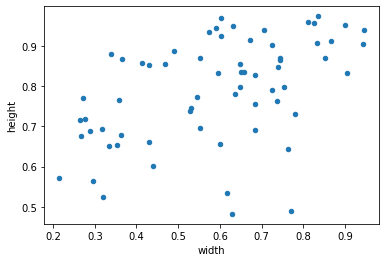

In [6]:
df.plot.scatter('width', 'height')

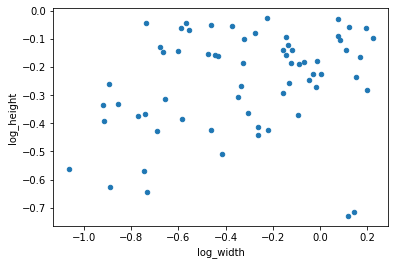

In [7]:
df.plot.scatter('log_width', 'log_height')

## KMeans Clustering
### Elbow Plot - to find the best number of Clusters

In [0]:
#Get the X by using log of width and height
X = df[['log_width', 'log_height']].to_numpy()


### IOU calculation

In [0]:
# given centroids find the maximum IOU of a bbox
def iou(box, centroids):
    x = np.minimum(np.exp(centroids[:, 0]), np.exp(box[0]))
    y = np.minimum(np.exp(centroids[:, 1]), np.exp(box[1]))

    intersection = x * y
    box_area = np.exp(box[0]) * np.exp(box[1])
    centroid_area = np.exp(centroids[:, 0]) * np.exp(centroids[:, 1])

    iou_ = intersection / (box_area + centroid_area - intersection)
    #return iou_
    return (np.max(iou_), np.argmax(iou_))

In [0]:
distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
centroids = {}
memberships = {}
miou = []
K = range(1, 21)

for k in K:
  kmeansModel = KMeans(n_clusters=k).fit(X)
  distortions.append(sum(np.min(cdist(X, kmeansModel.cluster_centers_, 
                      'euclidean'),axis=1)) / X.shape[0]) 
  inertias.append(kmeansModel.inertia_) 

  mapping1[k] = sum(np.min(cdist(X, kmeansModel.cluster_centers_, 
                'euclidean'),axis=1)) / X.shape[0] 
  mapping2[k] = kmeansModel.inertia_ 
  centroids[k] = kmeansModel.cluster_centers_
  maxiou = np.array([iou(b, centroids[k])  for b in X])
  memberships[k] = maxiou[:, 1].astype(np.uint8)
  # find mean of maximum IOU between bounding boxes and individual anchors
  miou.append(np.mean(maxiou[:, 0]))

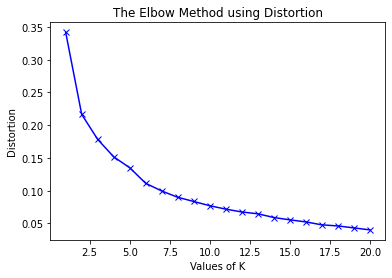

In [11]:
plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show()

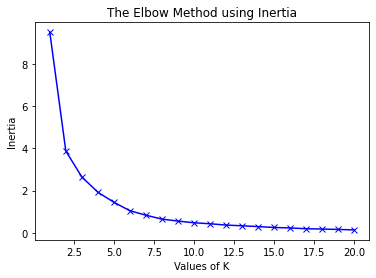

In [12]:
plt.plot(K, inertias, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show()

### Centroid Vs. MeanIoU plot

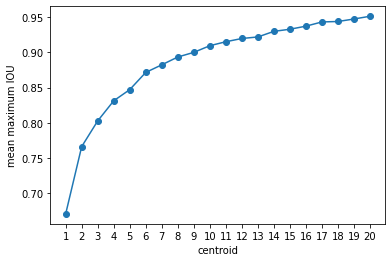

In [13]:
def plotIOU(X, Y):
  plt.scatter(X, Y)
  plt.plot(X, Y)
  plt.xlabel("centroid")
  plt.ylabel("mean maximum IOU")
  plt.xticks(np.arange(1, 21))
  plt.show()

plotIOU(K, miou)

##### after 5 it is going linear

### Cluster Plots

In [14]:

import seaborn as sns
def plotclusters(k):
  #ax = df.plot.scatter('log_width', 'log_height', c=f'cluster{k}', colormap='viridis')
  ax = sns.scatterplot('log_width', 'log_height', data=df, hue=memberships[k], style = memberships[k], palette="Set2")
  ax.scatter(centroids[k][:,0], centroids[k][:,1], marker='*', c='black')
  plt.show()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


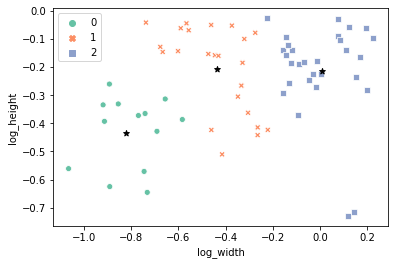

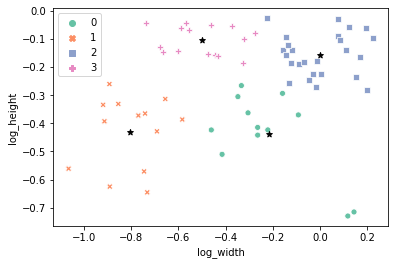

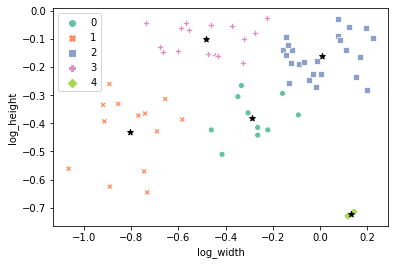

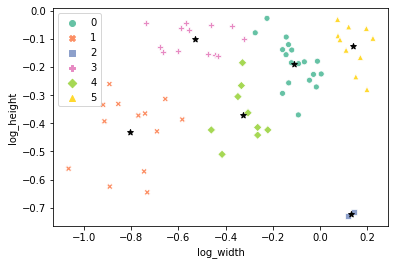

In [15]:
for k in [3, 4, 5, 6]:
  plotclusters(k)

### IOU based Distance Metric
#### IOU is a number between 0 and 1. The larger the better. So distance for k means should be 1 - IOU. We will use another package to achieve that.

In [16]:
!pip install pyclustering
# given centroids find the maximum IOU of a bbox
def ioudist(box, centroid):
    #print(centroid)
    x = np.minimum(np.exp(centroid[0]), np.exp(box[0]))
    y = np.minimum(np.exp(centroid[1]), np.exp(box[1]))

    intersection = x * y
    box_area = np.exp(box[0]) * np.exp(box[1])
    centroid_area = np.exp(centroid[0]) * np.exp(centroid[1])

    iou_ = intersection / (box_area + centroid_area - intersection)
    return 1 - iou_

In [0]:
from pyclustering.cluster.kmeans import kmeans, kmeans_visualizer
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from pyclustering.utils.metric import type_metric, distance_metric

metric = distance_metric(type_metric.USER_DEFINED, func=ioudist)
clusters = []
final_centers = []
mean_iou = []
for k in K:
  # Prepare initial centers using K-Means++ method.
  initial_centers = kmeans_plusplus_initializer(X, k).initialize()

  if k==1:
    kmeans_instance = kmeans(X, initial_centers)  
  else:
    kmeans_instance = kmeans(X, initial_centers, metric=metric)

  kmeans_instance.process()
  clusters.append(kmeans_instance.get_clusters())
  c = np.array(kmeans_instance.get_centers())
  final_centers.append(c)
  maxiou = np.array([iou(b, c)  for b in X])
  mean_iou.append(np.mean(maxiou[:, 0]))

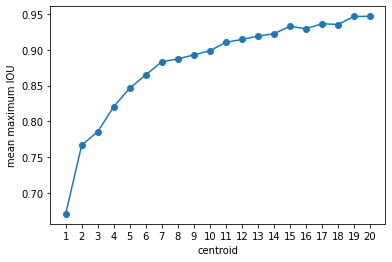

In [18]:
plotIOU(K, mean_iou)


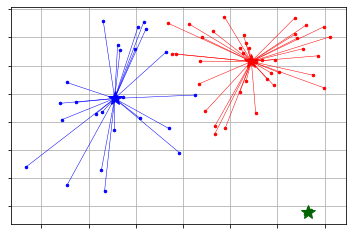

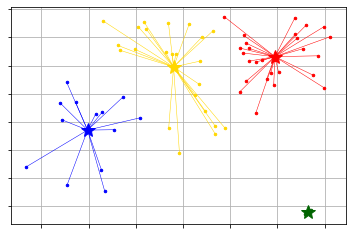

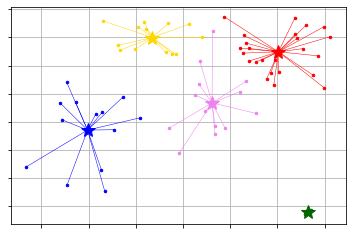

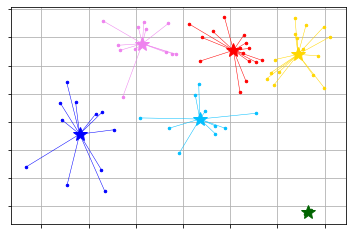

In [19]:

for k in range(2, 6):
  kmeans_visualizer.show_clusters(X, clusters[k], final_centers[k])